# Welcome the practice notebook 
--- 
The objective of this practice is to provide a hands-on experience in data exploration and cleaning. Please follow the instructions provided in the  notebook to complete the practice.

Installing pyspark

In [1]:
#!pip install pyspark

Importing the needed modules and creating the spark session

In [10]:
# importing spark session
from pyspark.sql import SparkSession

# data visualization modules 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 

# pandas module 
import pandas as pd

# pyspark SQL functions 
from pyspark.sql import functions as f

# creating the spark session
spark = SparkSession.builder.appName("Customer_Churn_Prediction").getOrCreate()
spark

Loading the `parctice-dataset.csv` file

In [3]:
data = spark.read.format('csv').option('header',True).option('inferSchema',True).load('practice_dataset.csv')
data.show(5)


+----------+------------+------------+------------+------------+----------------+
|EmployeeID|        KPI1|        KPI2|        KPI3|        KPI4|Current Employee|
+----------+------------+------------+------------+------------+----------------+
|         0|-1.039682384|-0.716426478|-0.513467693| 0.414661471|               0|
|         1| 0.237093465|-0.820123996|-0.865801274| 0.438661047|               0|
|         2|-2.077948003| 0.185688029|-0.132418305| 0.711280402|               1|
|         3|-0.684711628| 1.522335039| 1.674082146|-1.234292085|               1|
|         4|-1.137117653|-0.555136531|-0.176780706|-1.776008972|               0|
+----------+------------+------------+------------+------------+----------------+
only showing top 5 rows



How many rows and columns do we have in the dataset? 

In [4]:
data.count(), len(data.columns) 

(10000, 6)

Create a histogram matrix to analyse the distributions of the numerical columns. 

- *Hint 1: List of the numerical columns = `["KPI1","KPI2","KPI3","KPI4"]`* <br>
- *Hint 2: To create the histograms, first you will need to convert the pyspark dataframe into a pandas dataframe.*

In [5]:
data.dtypes

[('EmployeeID', 'int'),
 ('KPI1', 'double'),
 ('KPI2', 'double'),
 ('KPI3', 'double'),
 ('KPI4', 'double'),
 ('Current Employee', 'int')]

In [6]:
numerical_columns = ["KPI1","KPI2","KPI3","KPI4"]
data_num = data.select(numerical_columns).toPandas()

C:\Users\shihamf\AppData\Local\Temp\ipykernel_30716\767822754.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_num.hist(ax=ax)


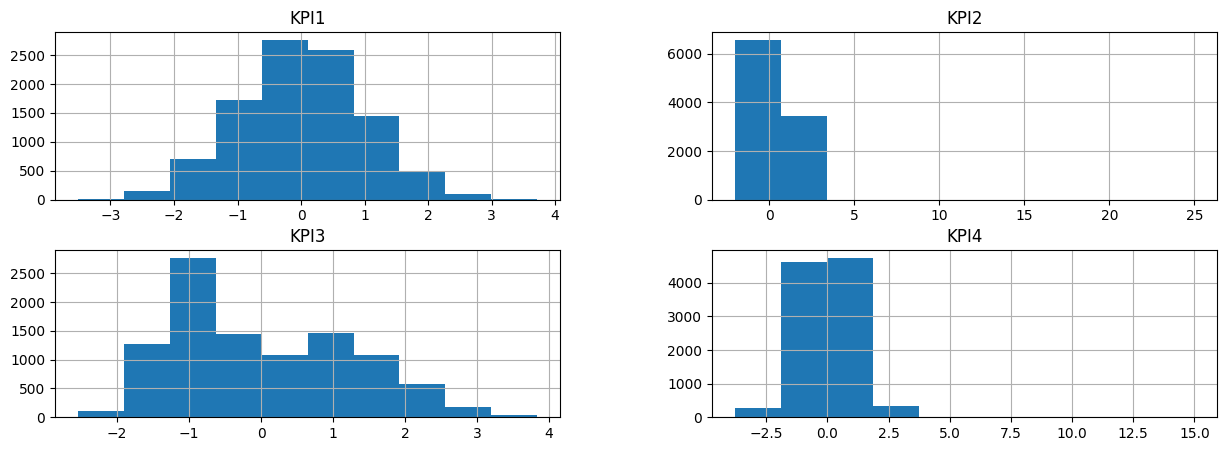

In [7]:
fig = plt.figure(figsize = (15,5))
ax = fig.gca()
data_num.hist(ax=ax)
plt.show()

Observe the distributions of the numerical columns in the histograms generated in the previous part.
- Find the columns with outilers
- Remove the outliers

In [8]:
data_num.describe()

,KPI1,KPI2,KPI3,KPI4
count,9996.000000,10000.000000,9998.000000,9997.000000
mean,0.016839,0.005517,0.004257,-0.002467
std,0.995379,1.150657,1.226913,1.019540
min,-3.513933,-2.006481,-2.545266,-3.781217
25%,-0.653304,-1.005110,-1.012192,-0.696898
50%,0.009675,-0.357864,-0.325057,-0.005431
75%,0.681623,1.006682,1.008359,0.678246
max,3.719265,25.000000,3.838220,15.000000


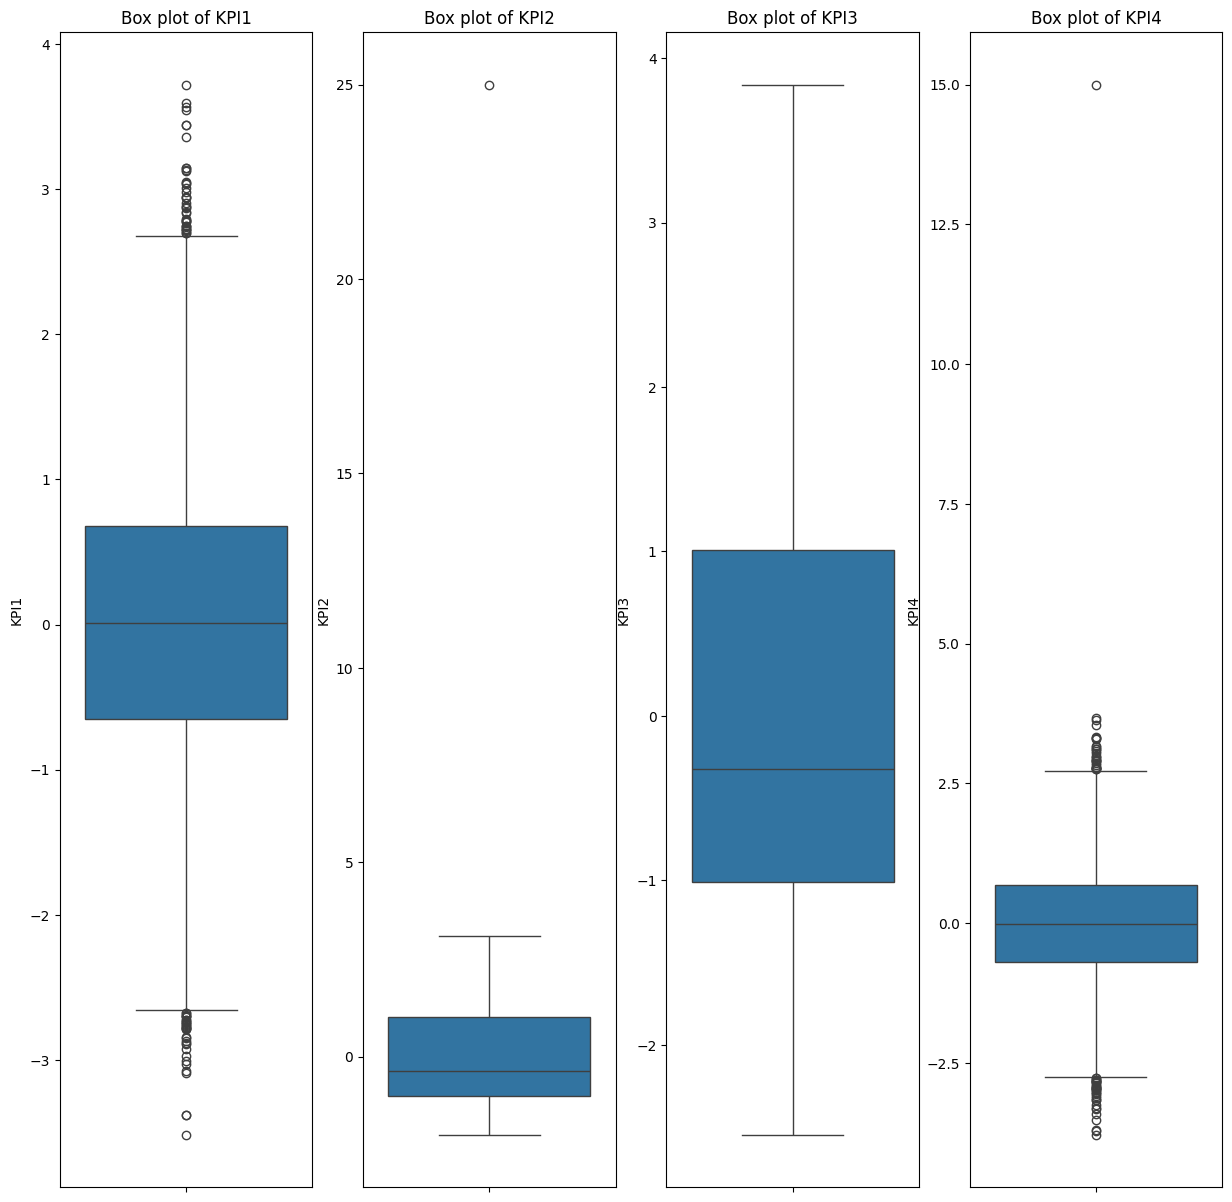

In [13]:
fig, axes = plt.subplots(1,4, figsize=(15,15))

for i, num_col in enumerate(data_num.columns):
    sns.boxplot(data_num[num_col], ax=axes[i])
    axes[i].set_title(f'Box plot of {num_col}')

In [15]:
#Removing the outlier in KPI2 and KPI4 columns
print('Count of rows before removing the outliers: ',data.count())
data = data.filter(f.col('KPI2') < 5)
data = data.filter(f.col('KPI4') < 5)
print('Count of rows after removing the outliers: ',data.count())

Count of rows before removing the outliers:  10000
Count of rows after removing the outliers:  9995


Find the missing values in the dataset. 

In [23]:
for columns in data.columns:
    data.select(
    f.count(
        f.when(f.col(columns).isNull(), 'Null')
        ).alias(f'Null_{columns}')
    ).show()

+---------------+
|Null_EmployeeID|
+---------------+
|              0|
+---------------+

+---------+
|Null_KPI1|
+---------+
|        4|
+---------+

+---------+
|Null_KPI2|
+---------+
|        0|
+---------+

+---------+
|Null_KPI3|
+---------+
|        2|
+---------+

+---------+
|Null_KPI4|
+---------+
|        0|
+---------+

+---------------------+
|Null_Current Employee|
+---------------------+
|                    0|
+---------------------+



In [24]:
#There are null values in KPI 1 & KPI3

Use **Mean Imputer** to fill the missing values

In [26]:
from pyspark.ml.feature import Imputer
columns_with_missing_values = ['KPI1', 'KPI3']
imputer = Imputer(
    inputCols = columns_with_missing_values,
    outputCols = columns_with_missing_values).setStrategy('mean')

imputer = imputer.fit(data)
data = imputer.transform(data)
data.show()

+----------+------------+------------+------------+------------+----------------+
|EmployeeID|        KPI1|        KPI2|        KPI3|        KPI4|Current Employee|
+----------+------------+------------+------------+------------+----------------+
|         0|-1.039682384|-0.716426478|-0.513467693| 0.414661471|               0|
|         1| 0.237093465|-0.820123996|-0.865801274| 0.438661047|               0|
|         2|-2.077948003| 0.185688029|-0.132418305| 0.711280402|               1|
|         3|-0.684711628| 1.522335039| 1.674082146|-1.234292085|               1|
|         4|-1.137117653|-0.555136531|-0.176780706|-1.776008972|               0|
|         5|-1.052934587| 0.119522573|-0.188215465|-0.867239924|               1|
|         6| 0.953745557| 0.738929252|   0.6416214|-1.069803493|               1|
|         7|-0.623751805| 1.770892731| 2.084658776| 0.436191916|               1|
|         8| 0.998210721| -0.74099461|-0.356348072|-1.950751965|               0|
|         9| 0.7

Again, find the missing values in the dataset to make sure no missing value exists.

In [27]:
for columns in data.columns:
    data.select(
    f.count(
        f.when(f.col(columns).isNull(), 'Null')
        ).alias(f'Null_{columns}')
    ).show()

+---------------+
|Null_EmployeeID|
+---------------+
|              0|
+---------------+

+---------+
|Null_KPI1|
+---------+
|        0|
+---------+

+---------+
|Null_KPI2|
+---------+
|        0|
+---------+

+---------+
|Null_KPI3|
+---------+
|        0|
+---------+

+---------+
|Null_KPI4|
+---------+
|        0|
+---------+

+---------------------+
|Null_Current Employee|
+---------------------+
|                    0|
+---------------------+

